**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/target-encoding).**

---


# Introduction #

In this exercise, you'll apply target encoding to features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset.

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex6 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("../input/fe-course-data/ames.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_32/3788892820.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


-------------------------------------------------------------------------------

First you'll need to choose which features you want to apply a target encoding to. Categorical features with a large number of categories are often good candidates. Run this cell to see how many categories each categorical feature in the *Ames* dataset has.

首先，您需要选择要应用目标编码的特征。具有大量类别的分类特征通常是很好的候选特征。运行该单元格，查看艾姆斯数据集中每个分类特征的类别数量。

In [2]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       6
SaleType         10
SaleCondition     6
dtype: int64

We talked about how the M-estimate encoding uses smoothing to improve estimates for rare categories. To see how many times a category occurs in the dataset, you can use the `value_counts` method. This cell shows the counts for `SaleType`, but you might want to consider others as well.

我们曾讨论过 M-estimate 编码如何使用平滑来改进对稀有类别的估计。

要查看一个类别在数据集中出现的次数，可以使用 value_counts 方法。本单元格显示的是 SaleType 的计数，但您也可以考虑其他类别。

In [6]:
print(df["SaleType"].value_counts(),
      df["MSSubClass"].value_counts(),
      df["Neighborhood"].value_counts(),
      df["OverallQual"].value_counts(),
      df["Exterior1st"].value_counts(),
      df["Exterior2nd"].value_counts())

WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: SaleType, dtype: int64 One_Story_1946_and_Newer_All_Styles          1079
Two_Story_1946_and_Newer                      575
One_and_Half_Story_Finished_All_Ages          287
One_Story_PUD_1946_and_Newer                  192
One_Story_1945_and_Older                      139
Two_Story_PUD_1946_and_Newer                  129
Two_Story_1945_and_Older                      128
Split_or_Multilevel                           118
Duplex_All_Styles_and_Ages                    109
Two_Family_conversion_All_Styles_and_Ages      61
Split_Foyer                                    48
Two_and_Half_Story_All_Ages                    23
One_and_Half_Story_Unfinished_All_Ages         18
PUD_Multilevel_Split_Level_Foyer               17
One_Story_with_Finished_Attic_All_Ages          6
One_and_Half_Story_PUD_All_Ages                 1
Name: MSSubClass, dtype: int64 

# 1) Choose Features for Encoding

Which features did you identify for target encoding? After you've thought about your answer, run the next cell for some discussion.

1) 选择编码特征
您为目标编码确定了哪些特征？思考答案后，运行下一个单元格进行讨论。

In [7]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

 The `Neighborhood` feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are `SaleType`, `MSSubClass`, `Exterior1st`, `Exterior2nd`. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

-------------------------------------------------------------------------------

Now you'll apply a target encoding to your choice of feature. As we discussed in the tutorial, to avoid overfitting, we need to fit the encoder on data heldout from the training set. Run this cell to create the encoding and training splits:

邻居 "功能看起来很有前途。在所有功能中，它的类别最多，而且有几个类别是罕见的。其他值得考虑的还有 SaleType、MSSubClass、Exterior1st 和 Exterior2nd。事实上，由于稀有类别的普遍存在，几乎所有的名义特征都值得尝试。

现在，您将对所选特征应用目标编码。正如我们在教程中讨论过的，为了避免过拟合，我们需要在训练集中保留的数据上拟合编码器。运行此单元创建编码和训练分割：

In [9]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0) #创建一个 20% 的分割来训练目标编码器
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

# 2) Apply M-Estimate Encoding

Apply a target encoding to your choice of categorical features. Also choose a value for the smoothing parameter `m` (any value is okay for a correct answer).

2) 应用 M-Estimate编码
为您选择的分类特征应用目标编码。同时为平滑参数 m 选择一个值（对于正确答案来说，任何值都可以）。

In [10]:

# YOUR CODE HERE: Create the MEstimateEncoder
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(
    cols=["SaleType","MSSubClass","Neighborhood","OverallQual","Exterior1st","Exterior2nd"], 
    m=5.0
)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)


# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [11]:
# Lines below will give you a hint or solution code
q_2.hint()
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Your code should look something like:
```python
encoder = MEstimateEncoder(
    cols=____,
    m=____,
)


# Fit the encoder on the encoding split
____.____(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)
```


<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

encoder = MEstimateEncoder(
    cols=["Neighborhood"],
    m=1.0,
)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

```

If you'd like to see how the encoded feature compares to the target, you can run this cell:
如果您想查看编码特征与目标特征的比较，可以运行此单元：

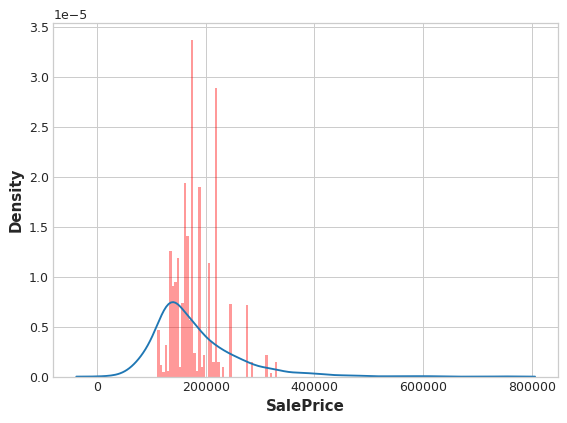

In [12]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

From the distribution plots, does it seem like the encoding is informative?

And this cell will show you the score of the encoded set compared to the original set:

从分布图来看，编码是否具有信息量？

这个单元格将显示编码集与原始集相比的得分：

In [13]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with Encoding: 0.1410 RMSLE


Do you think that target encoding was worthwhile in this case? Depending on which feature or features you chose, you may have ended up with a score significantly worse than the baseline. In that case, it's likely the extra information gained by the encoding couldn't make up for the loss of data used for the encoding.

在这种情况下，您认为目标编码值得吗？根据您选择的一个或多个特征，您可能会得到比基线差很多的分数。在这种情况下，编码获得的额外信息很可能无法弥补编码所损失的数据。

-------------------------------------------------------------------------------

In this question, you'll explore the problem of overfitting with target encodings. This will illustrate this importance of training fitting target encoders on data held-out from the training set.

So let's see what happens when we fit the encoder and the model on the *same* dataset. To emphasize how dramatic the overfitting can be, we'll mean-encode a feature that should have no relationship with `SalePrice`, a count: `0, 1, 2, 3, 4, 5, ...`.

在本题中，您将探讨目标编码器的过拟合问题。这将说明在训练集中保留的数据上训练拟合目标编码器的重要性。

因此，让我们看看在同一个数据集上拟合编码器和模型会发生什么。为了强调过拟合有多严重，我们将对一个与 SalePrice 没有任何关系的特征（一个计数）进行均值编码： 0, 1, 2, 3, 4, 5, ....

In [18]:
# 尝试使用不同的平滑参数m进行实验
# 可尝试的值包括0、1、5、50
# m = 0, X["Count"] , Score: 0.0290 RMSLE 
# m = 1, Score: 0.0295 RMSLE
# m = 5, Score: 0.0292 RMSLE
# m = 50 , Score: 0.0303 RMSLE
m = 0


X = df.copy()
y = X.pop('SalePrice')

# 创建一个非信息性特征
X["Count"] = range(len(X))
X["Count"][1] = 0  # 实际上需要一个重复值来规避MEstimateEncoder中的错误检查

# 在同一数据集上进行拟合和转换
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# 结果
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")



Score: 0.0303 RMSLE


均方根对数误差（Root Mean Squared Logarithmic Error，RMSLE）是一种常用于回归问题的损失函数。与均方误差（MSE）类似，RMSLE计算的是预测值与实际值之间的误差，但在计算误差之前会先取它们的自然对数。

RMSLE的公式为：
\begin{align*}
\text { RMSLE }=\sqrt{\frac{1}{n} \sum_{i=1}^n\left(\ln \left(y_i+1\right)-\ln \left(\hat{y}_i+1\right)\right)^2}
\end{align*}
其中, $y_i$ 是实际值, $\hat{y}_i$ 是预测值, $n$ 是样本数量。

RMSLE越小，意味着模型的预测越接近实际值，因此模型的性能越好。与RMSE相比，RMSLE对预测值和实际值之间的相对误差更敏感，而不是绝对误差。这使得RMSLE对大误差的惩罚较小，因此它常用于数据分布范围较广或对误差的绝对大小不太关心的情况。总的来说，RMSLE的值越小，模型的性能就越好。

Almost a perfect score!

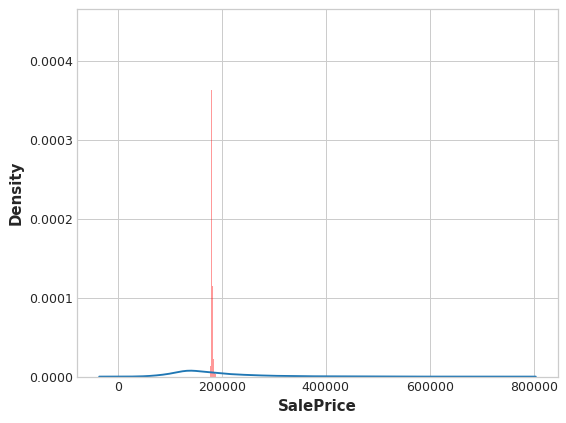

In [19]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

And the distributions are almost exactly the same, too.

分布情况也几乎完全相同。

# 3) Overfitting with Target Encoders

Based on your understanding of how mean-encoding works, can you explain how XGBoost was able to get an almost a perfect fit after mean-encoding the count feature?

# 3) 目标编码器的过度拟合

根据您对均值编码工作原理的理解，您能解释 XGBoost 是如何在对计数特征进行均值编码后获得几乎完美的拟合效果的吗？

In [20]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 


Since `Count` never has any duplicate values, the mean-encoded `Count` is essentially an exact copy of the target. In other words, mean-encoding turned a completely meaningless feature into a perfect feature.

Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!


由于 Count 不存在任何重复值，因此均值编码后的 Count 基本上是目标值的精确副本。换句话说，均值编码将一个完全无意义的特征变成了一个完美的特征。

现在，之所以能做到这一点，是因为我们在用于训练编码器的相同集合上训练了 XGBoost。如果我们使用的是保留集，这种 "假 "编码就不会转移到训练数据中。

这个教训告诉我们，**在使用目标编码器时，使用不同的数据集来训练编码器和训练模型是非常重要的**。否则，结果可能会非常令人失望！

In [23]:
# Uncomment this if you'd like a hint before seeing the answer
q_3.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> 
Suppose you had a dataset like:

| Count | Target |
|-------|--------|
| 0     | 10     |
| 1     | 5      |
| 2     | 30     |
| 3     | 22     |

What is the mean value of Target when Count is equal to 0? It's 10, since 0 only occurs in the first row. So what would be the result of mean-encoding Count, knowing that Count never has any duplicate values?


当 Count 等于 0 时，Target 的平均值是多少？是 10，因为 0 只出现在第一行。那么，在 Count 不存在重复值的情况下，对 Count 进行均值编码的结果是什么？

# The End #

That's it for *Feature Engineering*! We hope you enjoyed your time with us.

Now, are you ready to try out your new skills? Now would be a great time to join our [Housing Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) Getting Started competition. We've even prepared a [Bonus Lesson](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices) that collects all the work we've done together into a starter notebook.

# References #
Here are some great resources you might like to consult for more information. They all played a part in shaping this course:
- *The Art of Feature Engineering*, a book by Pablo Duboue.
- *An Empirical Analysis of Feature Engineering for Predictive Modeling*, an article by Jeff Heaton.
- *Feature Engineering for Machine Learning*, a book by Alice Zheng and Amanda Casari. The tutorial on clustering was inspired by this excellent book.
- *Feature Engineering and Selection*, a book by Max Kuhn and Kjell Johnson.

# 结束
《特征工程》到此结束！希望你在我们这里过得愉快。

现在，你准备好尝试你的新技能了吗？现在正是参加我们的住房价格入门竞赛的大好时机。我们甚至还准备了一堂奖励课程，将我们一起完成的所有工作收集到一本入门笔记本中。

# 参考资料
以下是一些很好的资源，您可以参考以获取更多信息。它们都对本课程的形成起到了一定的作用：

《特征工程的艺术》（The Art of Feature Engineering），Pablo Duboue 著。
〈用于预测建模的特征工程经验分析》（An Empirical Analysis of Feature Engineering for Predictive Modeling），Jeff Heaton 撰写的文章。
Alice Zheng 和 Amanda Casari 合著的《机器学习的特征工程》一书。关于聚类的教程就是受这本优秀书籍的启发而编写的。
《特征工程与选择》，Max Kuhn 和 Kjell Johnson 合著。

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*